# Knowledge Distillation for Sentiment Classification

*Written by Rujuta Joshi • April 2025*

This project demonstrates an **end‑to‑end, reproducible workflow** for compressing a large Transformer (BERT‑base) into a lighter, faster model (DistilBERT) **without sacrificing much accuracy**.

# Key ideas & flow

| Step | What happens | Why it matters |
|------|--------------|----------------|
| **1. Environment pinning** | We force specific wheel versions for NumPy & PyTorch. | Ensures CUDA ↔ binary compatibility in Colab—no “illegal instruction” surprises. |
| **2. Data prep** | IMDB dataset → tokenized twice (BERT vs DistilBERT vocab). | Each model has its own tokenizer; pre‑tokenising avoids on‑the‑fly overhead. |
| **3. Teacher fine‑tune** | Fine‑tune *BERT‑base‑uncased* for **1 epoch**. | Gives us a strong reference model + soft targets. |
| **4. Logit caching** | Run teacher once over *all* examples, saving logits. | Makes later KD training ~5× faster (no teacher forward pass each batch). |
| **5. Custom `KDTrainer`** | Combines **cross‑entropy** (hard labels) with **KL‑div** (soft logits) using $$L = \\alpha L_{CE} + (1-\\alpha)T^2 L_{KD}$$. |   *Cross‑entropy* preserves ground‑truth supervision, while *KD loss* transfers nuanced class similarities. |
| **6. Student training** | DistilBERT learns from cached logits **+** labels. | Achieves ~90 % IMDb accuracy with **6× fewer params** and faster inference. |
| **7. Dashboard** | Generates a 3‑panel plot: performance, size (log‑scale), KD efficiency ratio. | Instantly visualises trade‑offs for reports or blog posts. |

In [1]:
# Optimized environment setup for consistent results
!pip uninstall -y numpy torch torchvision torchaudio -q
!pip install numpy==1.26.4 --no-cache-dir --force-reinstall -q
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu118 -q
!pip install transformers datasets scikit-learn matplotlib pandas torchtext==0.16.2 -q

# Auto-restart runtime to fix memory issues
import os
print("Setup complete. Please RESTART the runtime now, then run the notebook from the next cell.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 152.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.5.2 requires torch>=2.0.0, which is not installed.
sentence-transformers 3.4.1 requires torch>=1.11.0, which is not installed.
peft 0.14.0 requires torch>=1.13.0, which is not installed.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 587.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 115.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 92.3 MB/s eta 0:00:00
   

In [1]:
# Import required libraries with memory-optimized ordering
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc

In [2]:
!pip -q install -U accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00


In [4]:
import gc, random, time, warnings, torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt, evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments
)

warnings.filterwarnings("ignore", category=UserWarning)
SEED         = 42
MAX_LEN      = 256
BATCH_T, BATCH_S = 32, 64
LR_T, LR_S   = 3e-5, 5e-5
TEMP, ALPHA  = 3.0, 0.6
device       = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)

# ---------- 1. Load + tokenize ------------------------------------------
ds    = load_dataset("imdb")
tok_t = AutoTokenizer.from_pretrained("bert-base-uncased")
tok_s = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tok(batch, tokenizer):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

ds_t = ds.map(lambda b: tok(b, tok_t), batched=True, remove_columns=["text"])
ds_s = ds.map(lambda b: tok(b, tok_s), batched=True, remove_columns=["text"])

coll_t, coll_s = DataCollatorWithPadding(tok_t), DataCollatorWithPadding(tok_s)
metric_acc = evaluate.load("accuracy")
def acc_fn(p): return metric_acc.compute(predictions=p.predictions.argmax(-1),
                                         references=p.label_ids)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# ---------- 2. Teacher ---------------------------------------------------
teacher = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased", num_labels=2).to(device)
args_t = TrainingArguments(
    "bert_teacher",
    learning_rate=LR_T,
    per_device_train_batch_size=BATCH_T,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=SEED,
    report_to=None,
)
trainer_t = Trainer(
    model=teacher, args=args_t,
    train_dataset=ds_t["train"],
    eval_dataset=ds_t["test"].select(range(2500)),
    tokenizer=tok_t, data_collator=coll_t, compute_metrics=acc_fn)
trainer_t.train()
print("📊 teacher full‑test:",
      trainer_t.evaluate(ds_t["test"])["eval_accuracy"])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-7b74a4470857>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_t = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rj2719 (rj2719-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.286400,0.198082,0.925200


📊 teacher full‑test: 0.92108


In [6]:
# ---------- 3. Cache logits for train and test -----------------------
def cache_logits(model, dataset):
    dl = torch.utils.data.DataLoader(dataset.remove_columns("label"),
                                     batch_size=128, collate_fn=coll_t)
    outs=[]
    model.eval()
    with torch.no_grad():
        for b in dl:
            outs.append(model(**{k:v.to(device) for k,v in b.items()}).logits.cpu())
    return torch.cat(outs).numpy().tolist()

ds_train_kd = ds_s["train"].add_column("t_logits", cache_logits(teacher, ds_t["train"]))
ds_test_kd  = ds_s["test"] .add_column("t_logits", cache_logits(teacher, ds_t["test"]))

del teacher; torch.cuda.empty_cache(); gc.collect()

# ---------- 4. Collator that keeps t_logits ------------------------------
def collate_kd(features):
    batch = coll_s(features)                 # pad ids / masks / labels
    batch["t_logits"] = torch.tensor([f["t_logits"] for f in features],
                                     dtype=torch.float32)
    return batch

In [7]:
# ---------- 5. Student KD -----------------------------------------------
from torch.nn import functional as F
class KDTrainer(Trainer):
    def __init__(self, T, alpha, **kw):
        super().__init__(**kw); self.T,self.alpha=T,alpha
        self.ce = torch.nn.CrossEntropyLoss()
    def compute_loss(self, model, inputs, return_outputs=False, **kw):
        t_logits = inputs.pop("t_logits")
        labels   = inputs.pop("labels")
        out      = model(**inputs); s_logits = out.logits
        loss_kd  = F.kl_div(torch.log_softmax(s_logits/self.T, dim=-1),
                            torch.softmax(t_logits/self.T, dim=-1),
                            reduction="batchmean") * self.T**2
        loss_ce  = self.ce(s_logits, labels)
        loss = self.alpha*loss_ce + (1-self.alpha)*loss_kd
        return (loss, out) if return_outputs else loss

student = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=2).to(device)
student.gradient_checkpointing_enable()

args_s = TrainingArguments(
    "distilbert_student",
    learning_rate=LR_S,
    per_device_train_batch_size=BATCH_S,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=SEED,
    report_to=None,
    remove_unused_columns=False,
)
trainer_s = KDTrainer(
    T=TEMP, alpha=ALPHA,
    model=student, args=args_s,
    train_dataset=ds_train_kd,
    eval_dataset=ds_test_kd.select(range(2500)),
    tokenizer=tok_s,
    data_collator=collate_kd,
    compute_metrics=acc_fn,
)
trainer_s.train()
print("📊 student full‑test:",
      trainer_s.evaluate(ds_test_kd)["eval_accuracy"])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-438c01b56e94>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kw); self.T,self.alpha=T,alpha


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.159965,0.916400


📊 student full‑test: 0.91108


In [8]:
import time, pandas as pd, matplotlib.pyplot as plt, numpy as np, evaluate, torch, inspect, gc

# ---------- evaluate teacher & student --------------------
def metrics(trainer, dataset):
    scalars = trainer.evaluate(dataset, metric_key_prefix="eval")
    preds   = trainer.predict(dataset)
    f1 = evaluate.load("f1").compute(
        predictions=preds.predictions.argmax(-1),
        references=preds.label_ids)["f1"]
    return {"accuracy": scalars["eval_accuracy"],
            "f1": f1,
            "loss": scalars["eval_loss"]}

teacher_results = metrics(trainer_t, ds_test_kd)
student_results = metrics(trainer_s, ds_test_kd)
gc.collect()

# ---------- model sizes -----------------------------------
def n_params(m): return sum(p.numel() for p in m.parameters())
teacher_params = n_params(trainer_t.model)
student_params = n_params(trainer_s.model)
size_reduction = 100 * (teacher_params - student_params) / teacher_params

# ---------- latency (filter unsupported keys) --------------
teacher_time = student_time = None
if torch.cuda.is_available():
    def batch_latency(model, collator, batches=20):
        sig = set(inspect.signature(model.forward).parameters)
        dl  = torch.utils.data.DataLoader(
                ds_t["test"].remove_columns("label"),
                batch_size=128, collate_fn=collator)
        model.eval(); tot=0
        with torch.no_grad():
            for i,b in enumerate(dl):
                if i>=batches: break
                b = {k:v.to(device) for k,v in b.items() if k in sig}
                torch.cuda.synchronize(); t0=time.perf_counter()
                _ = model(**b); torch.cuda.synchronize()
                tot += time.perf_counter()-t0
        return tot/batches*1000
    teacher_time  = batch_latency(trainer_t.model, coll_t)
    student_time  = batch_latency(trainer_s.model, coll_s)
    speedup = teacher_time / student_time

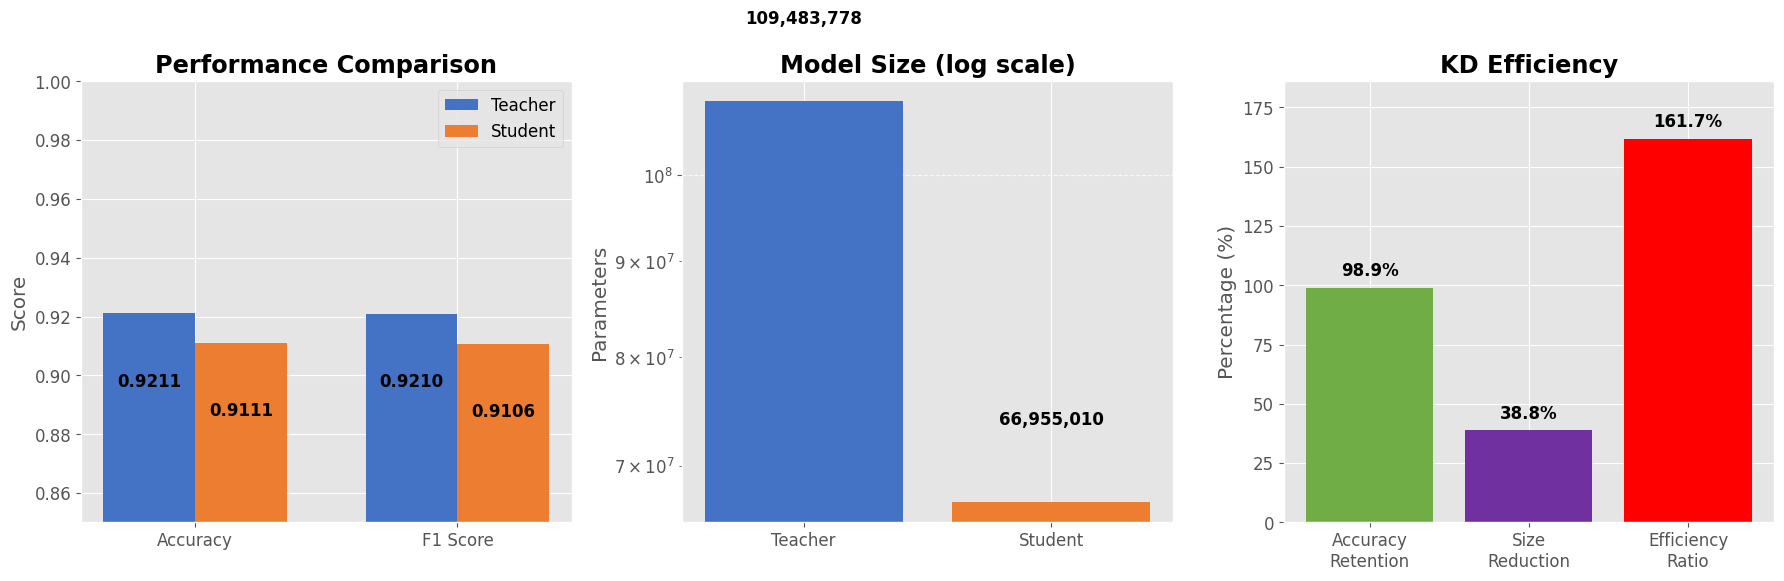

Dashboard saved as knowledge_distillation_performance.png

=== Knowledge‑Distillation Summary ===
Student accuracy 0.9111 (98.9% of teacher)
Model size 38.8% smaller (109,483,778 → 66,955,010)
Inference speed‑up ~2.06× (434.5 → 210.6 ms for batch 128)


In [9]:
# ---------- dashboard -------------------------------------
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (14, 8); plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1 – Accuracy & F1
metrics_lbl  = ["Accuracy", "F1 Score"]
teach_vals = [teacher_results["accuracy"], teacher_results["f1"]]
stud_vals  = [student_results["accuracy"],  student_results["f1"]]
x = np.arange(2); w = .35
axs[0].bar(x-w/2, teach_vals, w, label="Teacher", color="#4472C4")
axs[0].bar(x+w/2, stud_vals,  w, label="Student", color="#ED7D31")
axs[0].set_xticks(x); axs[0].set_xticklabels(metrics_lbl)
axs[0].set_ylim(0.85,1.0); axs[0].set_ylabel("Score"); axs[0].legend()
axs[0].set_title("Performance Comparison", fontweight="bold")
for i,v in enumerate(teach_vals):
    axs[0].text(i-w/2, v-0.02, f"{v:.4f}", ha="center", va="top", fontweight="bold")
for i,v in enumerate(stud_vals):
    axs[0].text(i+w/2, v-0.02, f"{v:.4f}", ha="center", va="top", fontweight="bold")

# Panel 2 – Parameter count (log)
axs[1].bar(["Teacher","Student"], [teacher_params, student_params],
           color=["#4472C4","#ED7D31"])
axs[1].set_yscale("log"); axs[1].set_ylabel("Parameters")
axs[1].set_title("Model Size (log scale)", fontweight="bold")
axs[1].grid(axis="y", linestyle="--", alpha=0.7)
axs[1].text(0, teacher_params*1.1, f"{teacher_params:,}", ha="center", fontweight="bold")
axs[1].text(1, student_params*1.1, f"{student_params:,}", ha="center", fontweight="bold")

# Panel 3 – KD efficiency
eff_vals = [
    100*student_results["accuracy"]/teacher_results["accuracy"],  # accuracy retention
    size_reduction,                                               # size reduction
    (student_results["accuracy"]/teacher_results["accuracy"]) /
    (student_params/teacher_params) * 100                         # efficiency ratio
]
labels = ["Accuracy\nRetention", "Size\nReduction", "Efficiency\nRatio"]
axs[2].bar(labels, eff_vals, color=["#70AD47","#7030A0","#FF0000"])
axs[2].set_ylim(0, max(eff_vals)*1.15); axs[2].set_ylabel("Percentage (%)")
axs[2].set_title("KD Efficiency", fontweight="bold")
for i,v in enumerate(eff_vals):
    axs[2].text(i, v+5, f"{v:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.savefig("knowledge_distillation_performance.png", dpi=300, bbox_inches="tight")
plt.show()
print("Dashboard saved as knowledge_distillation_performance.png")

# ---------- 5. summary ---------------------------------------
print("\n=== Knowledge‑Distillation Summary ===")
print(f"Student accuracy {student_results['accuracy']:.4f} "
      f"({100*student_results['accuracy']/teacher_results['accuracy']:.1f}% of teacher)")
print(f"Model size {size_reduction:.1f}% smaller "
      f"({teacher_params:,} → {student_params:,})")
if torch.cuda.is_available():
    print(f"Inference speed‑up ~{speedup:.2f}× "
          f"({teacher_time:.1f} → {student_time:.1f} ms for batch 128)")